# Dot Plot of Neuromodulator Receptor Expression in the Claustrum (MERFISH)

This notebook uses **MERFISH spatial transcriptomics** data from the Allen Brain Cell
(ABC) Atlas to visualize neuromodulator receptor expression across cell types in the
**claustrum (CLA)** and **dorsal endopiriform nucleus (EPd)** of the mouse brain.

### Key Advantage over 10x Data
Unlike the 10x snRNA-seq data (which only has coarse dissection regions like CTXsp),
MERFISH cells are registered to the **Allen Common Coordinate Framework (CCF)**, providing
fine parcellation. This means:
- **All cell types are CLA/EPd-localized**, including interneurons
- No need for the hybrid approach used in the 10x notebook
- Glia (astrocytes, microglia) are also structure-specific

### MERFISH Gene Panel Limitation
The MERFISH panel contains 550 genes. Of the 28 neuromodulator receptor genes
analyzed in the 10x notebooks, **11 are available**:
- **Serotonin (5)**: Htr1b, Htr1d, Htr2a, Htr3a, Htr7
- **Norepinephrine (2)**: Adra1a, Adra1b
- **Dopamine (4)**: Drd1, Drd2, Drd3, Drd5

In [1]:
import pandas as pd
import numpy as np
import re
import os
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

## 1. Initialize the ABC Atlas Cache

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_s3_cache(download_base)
print(f"Current manifest: {abc_cache.current_manifest}")

Current manifest: releases/20251031/manifest.json


## 2. Load Cell Metadata with CCF Parcellation

In [3]:
ccf_meta = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850-CCF',
    file_name='cell_metadata_with_parcellation_annotation',
    dtype={'cell_label': str}
)
ccf_meta.set_index('cell_label', inplace=True)
print(f"Total MERFISH cells with CCF: {len(ccf_meta):,}")

Total MERFISH cells with CCF: 3,739,961


## 3. Identify CLA and EPd Cells

Filter to cells within the **claustrum (CLA)** and **dorsal endopiriform nucleus (EPd)**
using CCF parcellation. These are adjacent structures in the cortical subplate (CTXsp)
that share excitatory cell types (CLA-EPd-CTX Car3 Glut, IT EP-CLA Glut).

In [4]:
# Filter to CLA and EPd
target_structures = ['CLA', 'EPd']
cla_cells = ccf_meta[ccf_meta['parcellation_structure'].isin(target_structures)].copy()
print(f"CLA + EPd cells: {len(cla_cells):,}")

print(f"\nBy structure:")
for struct, count in cla_cells.groupby('parcellation_structure', observed=True).size().items():
    print(f"  {struct}: {count:,} cells")

print(f"\nAll subclasses:")
for sc_name, count in cla_cells.groupby('subclass', observed=True).size().sort_values(ascending=False).items():
    print(f"  {sc_name}: {count:,} cells")

CLA + EPd cells: 11,179

By structure:
  CLA: 5,469 cells
  EPd: 5,710 cells

All subclasses:
  002 IT EP-CLA Glut: 2,391 cells
  027 L6b EPd Glut: 1,947 cells
  001 CLA-EPd-CTX Car3 Glut: 1,499 cells
  319 Astro-TE NN: 1,048 cells
  333 Endo NN: 765 cells
  327 Oligo NN: 759 cells
  053 Sst Gaba: 394 cells
  052 Pvalb Gaba: 323 cells
  028 L6b/CT ENT Glut: 227 cells
  326 OPC NN: 218 cells
  334 Microglia NN: 216 cells
  030 L6 CT CTX Glut: 209 cells
  331 Peri NN: 164 cells
  009 L2/3 IT PIR-ENTl Glut: 148 cells
  004 L6 IT CTX Glut: 134 cells
  029 L6b CTX Glut: 110 cells
  047 Sncg Gaba: 62 cells
  332 SMC NN: 61 cells
  330 VLMC NN: 56 cells
  114 COAa-PAA-MEA Barhl2 Glut: 51 cells
  049 Lamp5 Gaba: 49 cells
  050 Lamp5 Lhx6 Gaba: 49 cells
  046 Vip Gaba: 40 cells
  056 Sst Chodl Gaba: 35 cells
  003 L5/6 IT TPE-ENT Glut: 32 cells
  010 IT AON-TT-DP Glut: 29 cells
  038 DG-PIR Ex IMN: 21 cells
  051 Pvalb chandelier Gaba: 17 cells
  022 L5 ET CTX Glut: 15 cells
  032 L5 NP CTX Glu

In [5]:
# Select neuronal + glial subclasses with sufficient cells
# CLA/EPd excitatory neurons
cla_excitatory_keywords = ['CLA', 'EP-CLA', 'CLA-EPd']

subclass_counts = cla_cells.groupby('subclass', observed=True).size()

# Find excitatory subclasses matching CLA/EP keywords
cla_excitatory = []
for sc_name in subclass_counts.index:
    for kw in cla_excitatory_keywords:
        if kw in sc_name:
            cla_excitatory.append(sc_name)
            break

# Interneurons (spatially confirmed in CLA/EPd via CCF)
interneuron_candidates = [
    '052 Pvalb Gaba', '051 Pvalb chandelier Gaba',
    '053 Sst Gaba', '056 Sst Chodl Gaba',
    '046 Vip Gaba', '047 Sncg Gaba',
    '049 Lamp5 Gaba', '050 Lamp5 Lhx6 Gaba',
]
cla_interneurons = [s for s in interneuron_candidates if s in subclass_counts.index and subclass_counts[s] >= 30]

# Glia
glia_candidates = ['319 Astro-TE NN', '334 Microglia NN']
cla_glia = [s for s in glia_candidates if s in subclass_counts.index and subclass_counts[s] >= 30]

# Also include other excitatory types with sufficient cells
other_excitatory = []
for sc_name, count in subclass_counts.items():
    if count >= 40 and 'Glut' in sc_name and sc_name not in cla_excitatory:
        other_excitatory.append(sc_name)

all_selected = cla_excitatory + other_excitatory + cla_interneurons + cla_glia
all_selected = [s for s in all_selected if subclass_counts.get(s, 0) >= 30]

cla_selected = cla_cells[cla_cells['subclass'].isin(all_selected)].copy()

print(f"Selected cell types ({len(all_selected)} subclasses, {len(cla_selected):,} cells):")
for sc_name, count in cla_selected.groupby('subclass', observed=True).size().sort_values(ascending=False).items():
    tag = ''
    if sc_name in cla_excitatory:
        tag = ' [CLA excitatory]'
    elif sc_name in other_excitatory:
        tag = ' [other excitatory]'
    elif sc_name in cla_interneurons:
        tag = ' [interneuron]'
    elif sc_name in cla_glia:
        tag = ' [glia]'
    print(f"  {sc_name}: {count:,} cells{tag}")

Selected cell types (18 subclasses, 8,932 cells):
  002 IT EP-CLA Glut: 2,391 cells [CLA excitatory]
  027 L6b EPd Glut: 1,947 cells [other excitatory]
  001 CLA-EPd-CTX Car3 Glut: 1,499 cells [CLA excitatory]
  319 Astro-TE NN: 1,048 cells [glia]
  053 Sst Gaba: 394 cells [interneuron]
  052 Pvalb Gaba: 323 cells [interneuron]
  028 L6b/CT ENT Glut: 227 cells [other excitatory]
  334 Microglia NN: 216 cells [glia]
  030 L6 CT CTX Glut: 209 cells [other excitatory]
  009 L2/3 IT PIR-ENTl Glut: 148 cells [other excitatory]
  004 L6 IT CTX Glut: 134 cells [other excitatory]
  029 L6b CTX Glut: 110 cells [other excitatory]
  047 Sncg Gaba: 62 cells [interneuron]
  114 COAa-PAA-MEA Barhl2 Glut: 51 cells [other excitatory]
  049 Lamp5 Gaba: 49 cells [interneuron]
  050 Lamp5 Lhx6 Gaba: 49 cells [interneuron]
  046 Vip Gaba: 40 cells [interneuron]
  056 Sst Chodl Gaba: 35 cells [interneuron]


## 4. Define Receptor Gene Lists

In [6]:
gene = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850',
    file_name='gene'
)
gene.set_index('gene_identifier', inplace=True)

serotonin_receptors = ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7']
norepinephrine_receptors = ['Adra1a', 'Adra1b']
dopamine_receptors = ['Drd1', 'Drd2', 'Drd3', 'Drd5']

all_receptors = serotonin_receptors + norepinephrine_receptors + dopamine_receptors
available_genes = gene[gene['gene_symbol'].isin(all_receptors)]
receptor_genes = [g for g in all_receptors if g in set(available_genes['gene_symbol'])]
gene_ensembl_ids = available_genes.index.tolist()

print(f"Receptor genes in MERFISH panel: {len(receptor_genes)}/11")
print(f"  Serotonin: {[g for g in serotonin_receptors if g in receptor_genes]}")
print(f"  Norepinephrine: {[g for g in norepinephrine_receptors if g in receptor_genes]}")
print(f"  Dopamine: {[g for g in dopamine_receptors if g in receptor_genes]}")

Receptor genes in MERFISH panel: 11/11
  Serotonin: ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7']
  Norepinephrine: ['Adra1a', 'Adra1b']
  Dopamine: ['Drd1', 'Drd2', 'Drd3', 'Drd5']


## 5. Load Expression Data

In [7]:
csv_expr = 'cla_merfish_expression.csv'
csv_meta = 'cla_merfish_metadata.csv'

if os.path.exists(csv_expr):
    expression_data = pd.read_csv(csv_expr, index_col=0)
    print(f"Loaded from {csv_expr}: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes")
else:
    file_path = abc_cache.get_file_path(
        directory='MERFISH-C57BL6J-638850',
        file_name='C57BL6J-638850/log2'
    )
    print(f"Loading MERFISH expression from: {file_path}")
    print(f"File size: {os.path.getsize(file_path) / 1e9:.1f} GB")

    adata = anndata.read_h5ad(file_path, backed='r')
    print(f"Expression matrix: {adata.shape[0]:,} cells x {adata.shape[1]} genes")

    gene_mask = adata.var.index.isin(gene_ensembl_ids)
    cell_mask = adata.obs.index.isin(cla_selected.index)

    cell_idx = np.where(cell_mask)[0]
    gene_idx = np.where(gene_mask)[0]

    print(f"CLA/EPd cells found: {len(cell_idx):,}")
    print(f"Receptor genes found: {len(gene_idx)}")

    subset = adata[cell_idx, gene_idx].to_memory()
    gene_filtered = adata.var[gene_mask]

    expression_data = subset.to_df()
    expression_data.columns = gene_filtered['gene_symbol'].values
    expression_data = expression_data[receptor_genes]

    adata.file.close()
    del adata

    expression_data.to_csv(csv_expr)
    print(f"Saved to {csv_expr}")

cla_selected.loc[expression_data.index,
    ['subclass', 'supertype', 'class', 'neurotransmitter',
     'parcellation_structure', 'parcellation_substructure']
].to_csv(csv_meta)

print(f"\nExtracted expression: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes")

Loading MERFISH expression from: /home/user/data/abc_atlas/expression_matrices/MERFISH-C57BL6J-638850/20230830/C57BL6J-638850-log2.h5ad
File size: 7.6 GB


Expression matrix: 4,334,174 cells x 550 genes
CLA/EPd cells found: 8,932
Receptor genes found: 11


Saved to cla_merfish_expression.csv

Extracted expression: 8,932 cells x 11 genes


## 6. Build AnnData Object for Dot Plot

In [8]:
adata_cla = anndata.AnnData(
    X=expression_data.values,
    obs=cla_selected.loc[expression_data.index,
         ['subclass', 'supertype', 'class', 'neurotransmitter',
          'parcellation_structure']].copy(),
    var=pd.DataFrame(index=receptor_genes)
)

adata_cla.obs['subclass_short'] = adata_cla.obs['subclass'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_cla.obs['supertype_short'] = adata_cla.obs['supertype'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_cla.obs['subclass_short'] = pd.Categorical(adata_cla.obs['subclass_short'])
adata_cla.obs['supertype_short'] = pd.Categorical(adata_cla.obs['supertype_short'])

n_subclasses = adata_cla.obs['subclass_short'].cat.categories.size
n_supertypes = adata_cla.obs['supertype_short'].cat.categories.size
print(adata_cla)
print(f"\n{n_subclasses} subclasses, {n_supertypes} supertypes")

AnnData object with n_obs × n_vars = 8932 × 11
    obs: 'subclass', 'supertype', 'class', 'neurotransmitter', 'parcellation_structure', 'subclass_short', 'supertype_short'

18 subclasses, 86 supertypes


## 7. Dot Plot: CLA/EPd Cell Types (Subclass)

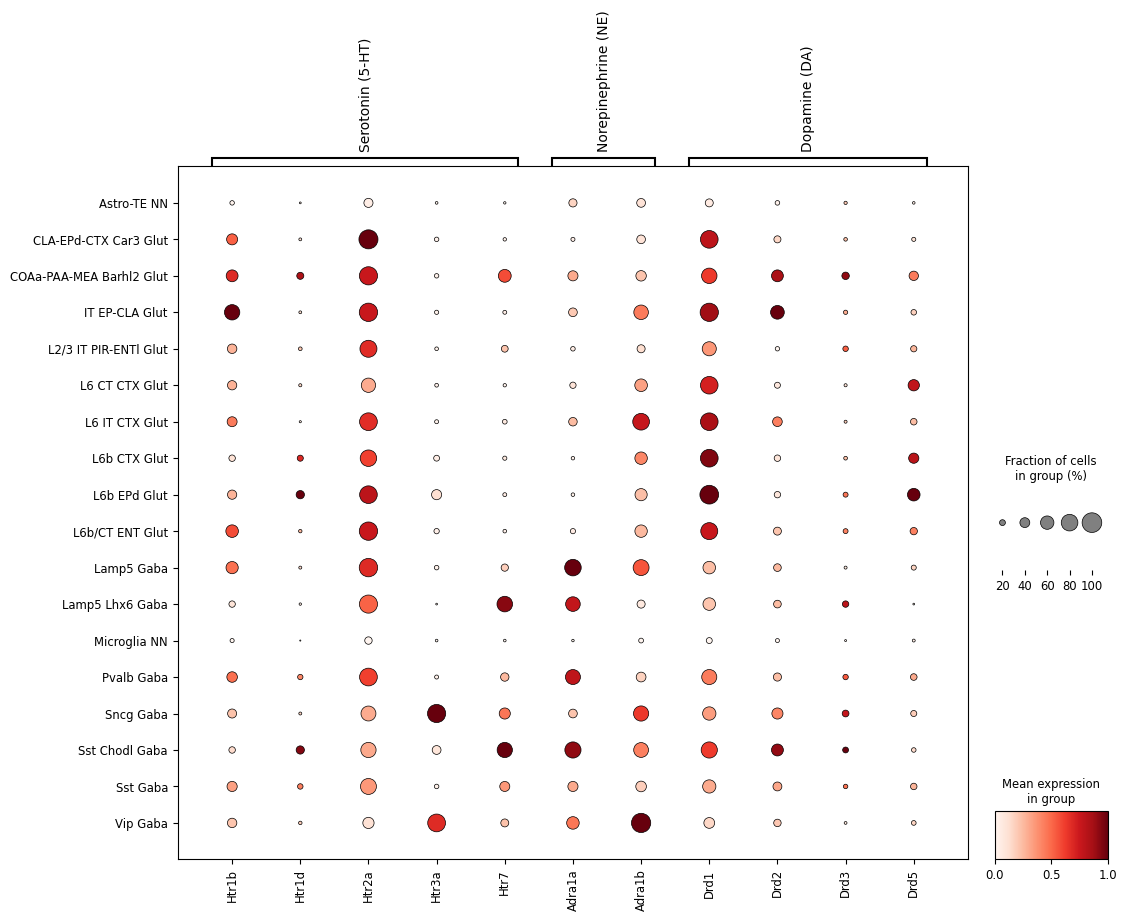

Saved: dotplot_CLA_MERFISH_receptors_by_subclass.png


In [9]:
receptor_groups = {
    'Serotonin (5-HT)': [g for g in serotonin_receptors if g in receptor_genes],
    'Norepinephrine (NE)': [g for g in norepinephrine_receptors if g in receptor_genes],
    'Dopamine (DA)': [g for g in dopamine_receptors if g in receptor_genes],
}

dp = sc.pl.dotplot(
    adata_cla,
    var_names=receptor_groups,
    groupby='subclass_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(6, n_subclasses * 0.5)),
    show=False,
    return_fig=True
)
dp.style(dot_edge_color='black', dot_edge_lw=0.5)
dp.savefig('dotplot_CLA_MERFISH_receptors_by_subclass.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_CLA_MERFISH_receptors_by_subclass.png")

## 8. Finer View: Grouped by Supertype

Supertypes with >= 30 cells: 30


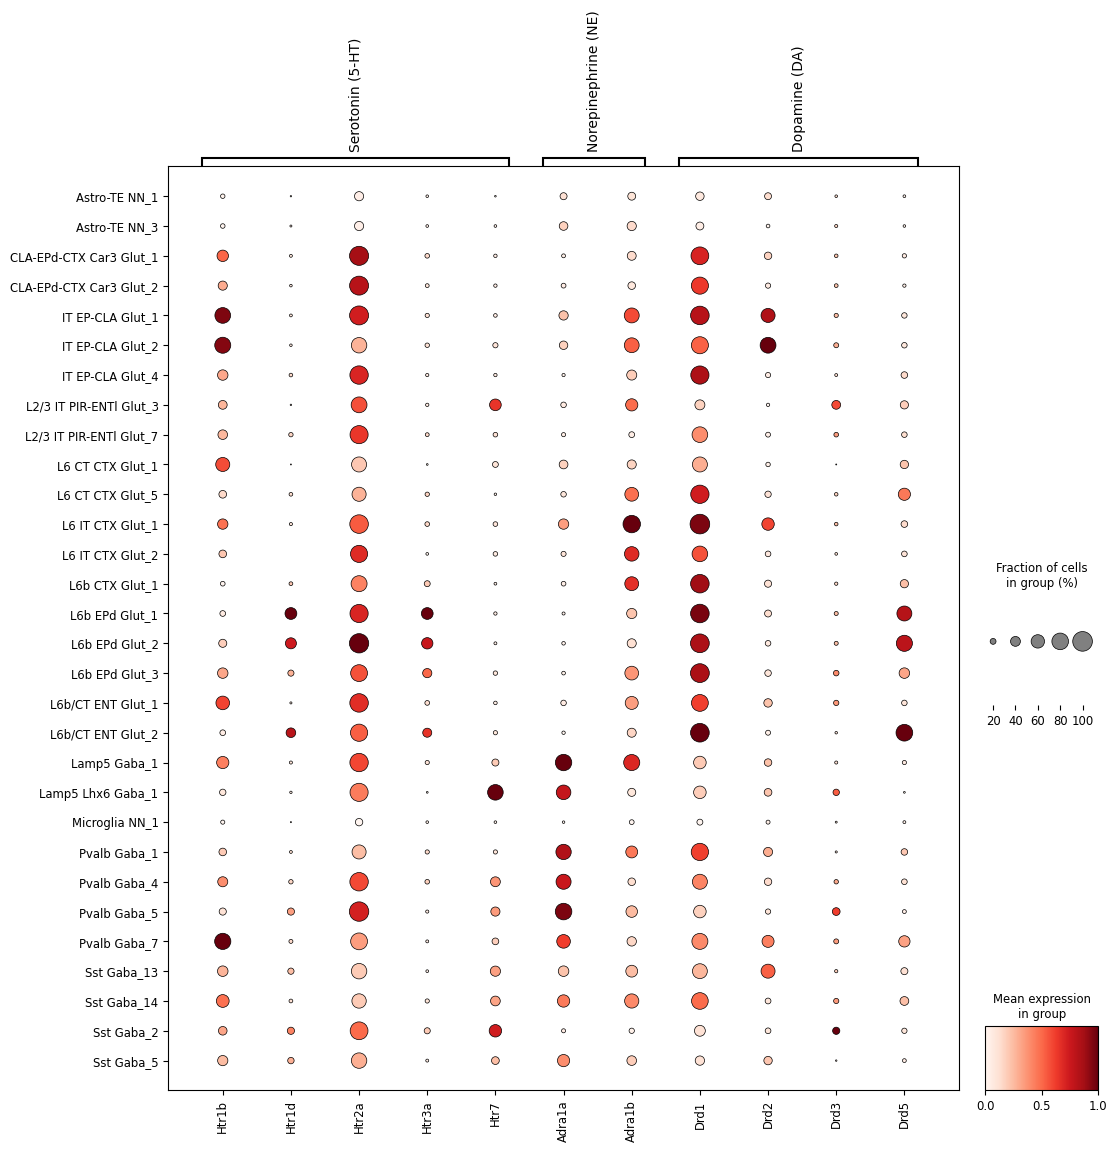

Saved: dotplot_CLA_MERFISH_receptors_by_supertype.png


In [10]:
min_cells = 30
supertype_counts = adata_cla.obs.groupby('supertype', observed=True).size()
valid_supertypes = supertype_counts[supertype_counts >= min_cells].index.tolist()

adata_st = adata_cla[adata_cla.obs['supertype'].isin(valid_supertypes)].copy()
adata_st.obs['supertype_short'] = pd.Categorical(adata_st.obs['supertype_short'])

n_st = len(valid_supertypes)
print(f"Supertypes with >= {min_cells} cells: {n_st}")

dp2 = sc.pl.dotplot(
    adata_st,
    var_names=receptor_groups,
    groupby='supertype_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(6, n_st * 0.4)),
    show=False,
    return_fig=True
)
dp2.style(dot_edge_color='black', dot_edge_lw=0.5)
dp2.savefig('dotplot_CLA_MERFISH_receptors_by_supertype.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_CLA_MERFISH_receptors_by_supertype.png")

## 9. CLA vs EPd Breakdown

Split each cell type by structure (CLA vs EPd) to compare receptor expression
between the claustrum proper and the dorsal endopiriform nucleus.

Cell type x structure groups (>= 30 cells): 24
  CLA-EPd-CTX Car3 Glut (CLA): 1,195
  CLA-EPd-CTX Car3 Glut (EPd): 304
  COAa-PAA-MEA Barhl2 Glut (EPd): 43
  IT EP-CLA Glut (CLA): 1,419
  IT EP-CLA Glut (EPd): 972
  L2/3 IT PIR-ENTl Glut (EPd): 142
  L6 CT CTX Glut (CLA): 199
  L6 IT CTX Glut (CLA): 134
  L6b CTX Glut (CLA): 69
  L6b CTX Glut (EPd): 41
  L6b EPd Glut (CLA): 402
  L6b EPd Glut (EPd): 1,545
  L6b/CT ENT Glut (CLA): 36
  L6b/CT ENT Glut (EPd): 191
  Lamp5 Lhx6 Gaba (EPd): 30
  Pvalb Gaba (CLA): 149
  Pvalb Gaba (EPd): 174
  Sncg Gaba (CLA): 37
  Sst Gaba (CLA): 166
  Sst Gaba (EPd): 228
  Astro-TE NN (CLA): 470
  Astro-TE NN (EPd): 578
  Microglia NN (CLA): 96
  Microglia NN (EPd): 120


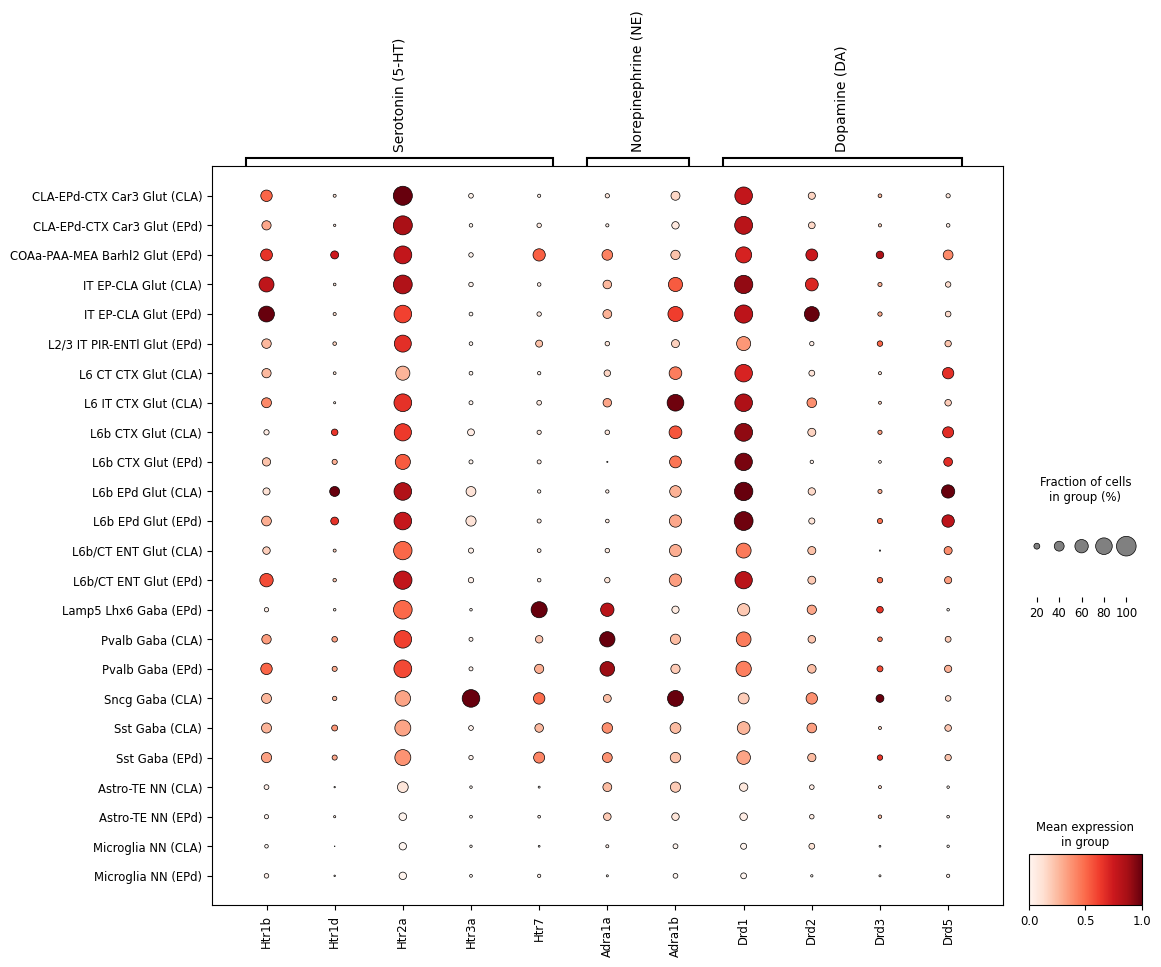

Saved: dotplot_CLA_MERFISH_receptors_by_structure.png


In [11]:
adata_cla.obs['cell_type_region'] = (
    adata_cla.obs['subclass_short'].astype(str) + ' (' +
    adata_cla.obs['parcellation_structure'].astype(str) + ')'
)

group_counts = adata_cla.obs.groupby('cell_type_region', observed=True).size()
valid_groups = group_counts[group_counts >= 30].index.tolist()
adata_struct = adata_cla[adata_cla.obs['cell_type_region'].isin(valid_groups)].copy()

def sort_key(name):
    parts = name.rsplit(' (', 1)
    sc = parts[0]
    sub = parts[1].rstrip(')') if len(parts) > 1 else ''
    if any(kw in sc for kw in ['Glut', 'Car3']):
        cat = 0
    elif 'NN' in sc:
        cat = 2
    else:
        cat = 1
    sub_order = {'CLA': 0, 'EPd': 1}
    return (cat, sc, sub_order.get(sub, 9))

sorted_groups = sorted(valid_groups, key=sort_key)
adata_struct.obs['cell_type_region'] = pd.Categorical(
    adata_struct.obs['cell_type_region'], categories=sorted_groups, ordered=True
)

n_groups = len(sorted_groups)
print(f"Cell type x structure groups (>= 30 cells): {n_groups}")
for g in sorted_groups:
    print(f"  {g}: {group_counts[g]:,}")

dp3 = sc.pl.dotplot(
    adata_struct,
    var_names=receptor_groups,
    groupby='cell_type_region',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(8, n_groups * 0.4)),
    show=False,
    return_fig=True
)
dp3.style(dot_edge_color='black', dot_edge_lw=0.5)
dp3.savefig('dotplot_CLA_MERFISH_receptors_by_structure.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_CLA_MERFISH_receptors_by_structure.png")

## 10. Summary Statistics

In [12]:
expr_df = pd.DataFrame(
    adata_cla.X,
    index=adata_cla.obs.index,
    columns=adata_cla.var.index
)
expr_df['subclass'] = adata_cla.obs['subclass_short'].values

mean_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].mean()
frac_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].apply(
    lambda x: (x > 0).mean()
)

print("=" * 70)
print("Mean Expression (log2) by CLA/EPd Subclass — MERFISH")
print("=" * 70)
display(mean_expr.round(2))

print("\n" + "=" * 70)
print("Fraction of Expressing Cells by CLA/EPd Subclass — MERFISH")
print("=" * 70)
display(frac_expr.round(3))

Mean Expression (log2) by CLA/EPd Subclass — MERFISH


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
subclass,,,,,,,,,,,
Astro-TE NN,0.13,0.04,0.44,0.07,0.05,0.30,0.38,0.34,0.15,0.09,0.06
CLA-EPd-CTX Car3 Glut,0.75,0.07,3.14,0.13,0.08,0.12,0.38,2.03,0.30,0.10,0.12
COAa-PAA-MEA Barhl2 Glut,0.94,0.34,2.46,0.11,0.71,0.50,0.64,1.65,1.07,0.25,0.38
IT EP-CLA Glut,1.31,0.07,2.46,0.12,0.10,0.36,1.16,2.22,1.22,0.11,0.17
L2/3 IT PIR-ENTl Glut,0.45,0.10,2.23,0.12,0.31,0.14,0.44,1.03,0.13,0.16,0.23
L6 CT CTX Glut,0.45,0.08,1.16,0.13,0.07,0.22,0.89,1.85,0.21,0.07,0.65
L6 IT CTX Glut,0.65,0.04,2.22,0.12,0.13,0.42,1.89,2.16,0.61,0.09,0.22
L6b CTX Glut,0.25,0.28,2.04,0.20,0.13,0.09,1.07,2.37,0.23,0.10,0.67
L6b EPd Glut,0.45,0.39,2.58,0.49,0.11,0.09,0.68,2.49,0.22,0.15,0.82



Fraction of Expressing Cells by CLA/EPd Subclass — MERFISH


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
subclass,,,,,,,,,,,
Astro-TE NN,0.139,0.043,0.359,0.071,0.061,0.312,0.342,0.302,0.144,0.093,0.068
CLA-EPd-CTX Car3 Glut,0.463,0.077,0.960,0.139,0.098,0.123,0.336,0.868,0.256,0.105,0.125
COAa-PAA-MEA Barhl2 Glut,0.510,0.255,0.902,0.137,0.569,0.412,0.431,0.725,0.510,0.275,0.373
IT EP-CLA Glut,0.720,0.077,0.913,0.128,0.118,0.338,0.670,0.907,0.620,0.130,0.186
L2/3 IT PIR-ENTl Glut,0.378,0.108,0.824,0.108,0.243,0.142,0.304,0.642,0.135,0.182,0.216
L6 CT CTX Glut,0.368,0.086,0.656,0.110,0.096,0.220,0.555,0.861,0.206,0.086,0.478
L6 IT CTX Glut,0.403,0.052,0.873,0.119,0.149,0.328,0.806,0.866,0.388,0.082,0.231
L6b CTX Glut,0.227,0.209,0.791,0.200,0.127,0.100,0.545,0.873,0.227,0.109,0.418
L6b EPd Glut,0.366,0.317,0.866,0.413,0.117,0.104,0.528,0.940,0.224,0.161,0.554
